IND 320 - NMBU

Project work, part 2 - Data Sources

\newpage

## AI usage

I used AI tools mainly to help with some technical parts of the project.
They helped me understand how to connect Python to MongoDB Atlas using pymongo, and how to manage connection errors related to DNS or environment variables.
I also used them to check the correct structure for the secrets.toml file and to make sure the data pipeline worked with Streamlit Cloud.
In addition, I used AI support to debug some issues in my Jupyter Notebook, especially when reading data from the Elhub API and converting it into a clean DataFrame.
Finally, AI tools helped me rephrase some explanations and write the project log in clearer English.

## Log describing

In this second part, the goal was to connect the dashboard to real data instead of using only local files.
I worked on creating a full pipeline: Elhub API → CSV → MongoDB Atlas → Streamlit.

I started by calling the Elhub Energy Data API to get hourly production data for 2021.
For each Norwegian price area (NO1–NO5) and each production group (hydro, wind, solar, thermal, other), I collected all values and converted them into a DataFrame.
I saved the result as a CSV file to keep a local copy of the raw data.

Then, I set up MongoDB Atlas to store the dataset in the cloud.
The idea was that Streamlit would read directly from MongoDB instead of Cassandra.
This part took time because my connection to Atlas kept failing.
After several tests, I found that the issue came from DNS resolution — my local DNS couldn’t find the SRV records for the cluster.
I tried different fixes, including switching to Google’s DNS and using my phone’s hotspot, but it didn’t fully solve the problem.
To move forward, I uploaded the CSV file manually into MongoDB Atlas.
That worked fine and the collection was created successfully.

Once the data was stored, I updated the Streamlit app to read it using pymongo.
I also moved my credentials to a secrets.toml file, so they stay private when deploying on Streamlit Cloud.

The page now loads the MongoDB data and creates two charts:

- pie chart showing the production share by source for one area;

- line chart showing hourly production by group and month.

This part allowed me to connect everything together.
Even with the DNS issues, I managed to complete the data flow and make the dashboard fully functional with cloud data.


## Github and Streamlit app links

- Streamlit app: [https://liserochat-ind320-dashboard.streamlit.app
](https://liserochat-ind320-dashboard.streamlit.app)  
- GitHub repository: [https://github.com/lise-dev/liserochat-ind320-dashboard.git](https://github.com/lise-dev/liserochat-ind320-dashboard.git)

\newpage

## Setup and imports

In [10]:
import os
from pathlib import Path
import pandas as pd
import requests
from datetime import datetime
from pyspark.sql import SparkSession
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt

## Define constants

I define the constants that will be used throughout the notebook.

They include:
- API parameters for fetching data from Elhub.
- Lists of price areas, production groups, and months for 2021.
- MongoDB connection details for storing the processed dataset online.


In [ ]:
# API settings
API_BASE = "https://api.elhub.no/energy-data/v0/price-areas"  
DATASET  = "PRODUCTION_PER_GROUP_MBA_HOUR"

# Production and area constants
PRICE_AREAS = ["NO1","NO2","NO3","NO4","NO5"]
PROD_GROUPS = ["solar","hydro","wind","thermal","other"]
MONTHS = [f"2021-{m:02d}" for m in range(1,13)]

# MongoDB connection details
MONGO_URI = "mongodb+srv://@:@@cluster0.ilespbc.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0"
MONGO_DB = "ind320"
MONGO_COLLECTION = "elhub_production_2021"

## Define helper for monthly time ranges

The Elhub API requires UTC timestamps for the start and end of each request.  
I created a helper function that takes a year-month string (for example `"2021-01"`) and returns the corresponding start and end timestamps in UTC format.  

In [3]:
def month_range_utc(ym: str):
    start = pd.Timestamp(f"{ym}-01 00:00:00", tz="UTC")
    end   = (start + pd.offsets.MonthEnd(1)) + pd.Timedelta(days=1)
    
    def fmt(ts):
        s = ts.strftime("%Y-%m-%dT%H:%M:%S%z")
        return s[:-2] + ":" + s[-2:]
    
    return fmt(start), fmt(end)

## Fetch hourly production data for one area and month

This function sends a request to the Elhub API for one production group, one price area, and one month.  
It builds the correct query parameters (`priceArea`, `startDate`, `endDate`, `productionGroup`), retrieves the JSON response, and converts the relevant data into a clean Pandas DataFrame.

The returned dataframe contains the following columns:
- `price_area`
- `production_group`
- `start_time`
- `quantity_kwh`


In [4]:
def fetch_month_one_group(area: str, ym: str, group: str) -> pd.DataFrame:
    """Fetch hourly production data for a specific area, month and production group."""
    
    start = pd.Timestamp(f"{ym}-01").strftime("%Y-%m-%d")
    end = (pd.Timestamp(f"{ym}-01") + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")

    url = f"https://api.elhub.no/energy-data/v0/price-areas/{area}"
    params = {
        "dataset": "PRODUCTION_PER_GROUP_MBA_HOUR",
        "startDate": start,
        "endDate": end,
        "productionGroup": group,
    }

    response = requests.get(url, params=params, timeout=60)
    response.raise_for_status()
    data_json = response.json()

    data = data_json.get("data", [])
    if not data:
        return pd.DataFrame(columns=["price_area", "production_group", "start_time", "quantity_kwh"])
    
    attributes = data[0].get("attributes", {})
    items = attributes.get("productionPerGroupMbaHour", [])

    if not items:
        return pd.DataFrame(columns=["price_area", "production_group", "start_time", "quantity_kwh"])

    df = (
        pd.json_normalize(items)[["priceArea", "productionGroup", "startTime", "quantityKwh"]]
        .rename(columns={
            "priceArea": "price_area",
            "productionGroup": "production_group",
            "startTime": "start_time",
            "quantityKwh": "quantity_kwh",
        })
    )

    df["start_time"] = pd.to_datetime(df["start_time"], utc=True, errors="coerce")
    return df


## Loop over all areas and months of 2021

In this step, I loop through all five Norwegian price areas and the twelve months of 2021.  
For each area, month, and production group, the `fetch_month_one_group()` function is called.  
All the resulting DataFrames are combined into a single dataset called `raw_df`.


In [5]:
all_chunks = []

for area in PRICE_AREAS:
    for ym in MONTHS:
        for g in PROD_GROUPS:
            try:
                dfm = fetch_month_one_group(area, ym, g)
                if not dfm.empty:
                    all_chunks.append(dfm)
                else:
                    print(f"Empty result for {area} {ym} {g}")
            except Exception as e:
                print(f"Failed for {area} {ym} {g}: {e}")

if all_chunks:
    raw_df = pd.concat(all_chunks, ignore_index=True)
else:
    raw_df = pd.DataFrame(columns=["price_area", "production_group", "start_time", "quantity_kwh"])

print("Total number of rows and columns:", raw_df.shape)
raw_df.head()


Empty result for NO5 2021-01 wind
Empty result for NO5 2021-02 wind
Empty result for NO5 2021-03 wind
Empty result for NO5 2021-04 wind
Empty result for NO5 2021-05 wind
Total number of rows and columns: (208248, 4)


,price_area,production_group,start_time,quantity_kwh
0,NO1,solar,2020-12-31 23:00:00+00:00,6.106
1,NO1,solar,2021-01-01 00:00:00+00:00,4.030
2,NO1,solar,2021-01-01 01:00:00+00:00,3.982
3,NO1,solar,2021-01-01 02:00:00+00:00,8.146
4,NO1,solar,2021-01-01 03:00:00+00:00,8.616


## Save the raw data to CSV

Once all data are collected, I export the full dataset to a CSV file.  
This file will be used later in Spark (for Cassandra) and in the Streamlit app.

The CSV is saved in the project data folder:
`/home/lse/Documents/IND320/liserochat-ind320-dashboard/app/data/elhub_production_2021_raw.csv`

In [6]:
out_path = Path("/home/lse/Documents/IND320/liserochat-ind320-dashboard/app/data/elhub_production_2021_raw.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)

if raw_df.empty:
    print("No CSV file was created.")
else:
    raw_df.to_csv(out_path, index=False)
    print(f"CSV file successfully saved to: {out_path.resolve()}")

CSV file successfully saved to: /home/lse/Documents/IND320/liserochat-ind320-dashboard/app/data/elhub_production_2021_raw.csv


## Initialize Spark with the Cassandra connector

Here I create a `SparkSession` configured to connect to the local Cassandra instance running in Docker  
(on `127.0.0.1:9042`). The Spark Cassandra connector is automatically downloaded via  
`spark.jars.packages` when the session starts.


In [7]:
# Stop any previous Spark session if running
try:
    spark.stop()
except Exception:
    pass

# Create a new Spark session configured for Cassandra
spark = (
    SparkSession.builder
    .appName("IND320-Elhub-2021")
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.13:3.5.0")
    .config("spark.cassandra.connection.host", "127.0.0.1")
    .config("spark.cassandra.connection.port", "9042")
    .config("spark.cassandra.output.consistency.level", "LOCAL_ONE")
    .getOrCreate()
)

spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/24 14:28:01 WARN Utils: Your hostname, lse-Creator-Z17-A12UGST, resolves to a loopback address: 127.0.1.1; using 10.20.3.60 instead (on interface wlo1)
25/10/24 14:28:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/lse/Documents/IND320/liserochat-ind320-dashboard/.venv-spark/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/lse/.ivy2.5.2/cache
The jars for the packages stored in: /home/lse/.ivy2.5.2/jars
com.datastax.spark#spark-cassandra-connector_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-1cbd3eb6-6857-4df6-910c-c4dfc30891c3;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.13;3.5.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.13;3.5.0 in central


## Prepare the dataframe we want to persist in Cassandra

Before inserting data into Cassandra, I check that the dataframe `raw_df` exists,  
is not empty, and includes the expected columns with correct names:
- `price_area`
- `production_group`
- `start_time`
- `quantity_kwh`

In [8]:
# Check that the dataframe is ready for Cassandra
if "raw_df" not in globals():
    raise ValueError("raw_df is not defined. Please run the previous steps first.")

if raw_df.empty:
    raise ValueError("raw_df is empty. Fetch data from the API before continuing.")

required_cols = ["price_area", "production_group", "start_time", "quantity_kwh"]
for col in required_cols:
    if col not in raw_df.columns:
        raise ValueError(f"Missing column: {col}")

raw_df.head()


,price_area,production_group,start_time,quantity_kwh
0,NO1,solar,2020-12-31 23:00:00+00:00,6.106
1,NO1,solar,2021-01-01 00:00:00+00:00,4.030
2,NO1,solar,2021-01-01 01:00:00+00:00,3.982
3,NO1,solar,2021-01-01 02:00:00+00:00,8.146
4,NO1,solar,2021-01-01 03:00:00+00:00,8.616


## Write the data into Cassandra using Spark

Here I convert the pandas dataframe (`raw_df`) to a Spark DataFrame  
and insert it into the Cassandra keyspace **elhub**, table **production_2021**.

I use `mode("append")` to keep existing rows and only add new ones.  
The Cassandra table schema was already created with the primary key  
`(price_area, start_time, production_group)`.

In [9]:
# Set Cassandra connection parameters for Spark
spark.conf.set("spark.cassandra.connection.host", "127.0.0.1")
spark.conf.set("spark.cassandra.connection.port", "9042")
spark.conf.set("spark.cassandra.output.consistency.level", "LOCAL_ONE")

# Basic checks before writing
print("Columns:", raw_df.columns.tolist())
print("Types:\n", raw_df.dtypes.head())
print("Rows:", len(raw_df))

# Convert pandas dataframe to Spark dataframe
sdf = spark.createDataFrame(raw_df)

# Write to Cassandra
try:
    (
        sdf.write
        .format("org.apache.spark.sql.cassandra")
        .mode("append")
        .options(keyspace="elhub", table="production_2021")
        .save()
    )
    print("Data successfully written to elhub.production_2021")
except Exception as e:
    print("Write failed:", e)
    raise


Columns: ['price_area', 'production_group', 'start_time', 'quantity_kwh']
Types:
 price_area                       object
production_group                 object
start_time          datetime64[ns, UTC]
quantity_kwh                    float64
dtype: object
Rows: 208248


Data successfully written to elhub.production_2021


## Read back from Cassandra and inspect

I now read the table `elhub.production_2021` back from Cassandra using Spark.  
This allows me to confirm that the data was correctly written.  
Then, I convert it to a pandas dataframe for later use (for plotting and MongoDB upload).


In [10]:
# Read data from Cassandra
sdf_check = (
    spark.read
    .format("org.apache.spark.sql.cassandra")
    .options(keyspace="elhub", table="production_2021")
    .load()
    .select("price_area", "production_group", "start_time", "quantity_kwh")
)

# Convert to pandas dataframe
pdf = sdf_check.toPandas()

print("Data shape:", pdf.shape)
pdf.head()


Data shape: (208248, 4)


,price_area,production_group,start_time,quantity_kwh
0,NO5,hydro,2021-01-01 00:00:00,4068096.50
1,NO5,other,2021-01-01 00:00:00,0.00
2,NO5,solar,2021-01-01 00:00:00,3.72
3,NO5,thermal,2021-01-01 00:00:00,77742.00
4,NO5,hydro,2021-01-01 01:00:00,4104306.00


## Insert the curated data into MongoDB

In this step I push the cleaned dataset to MongoDB Atlas.

The goal is:
- Store the data in a cloud database (`ind320.elhub_production_2021`)
- Let the Streamlit app read directly from MongoDB (so the app does not have to connect to Cassandra)

I use `pymongo` to connect to the cluster.  
The connection string is stored in my local secrets and is not committed to GitHub.

In [16]:
# Connect to MongoDB Atlas
client = MongoClient(MONGO_URI)
db = client[MONGO_DB]
collection = db[MONGO_COLLECTION]

# Load the cleaned dataset from the CSV created earlier
csv_path = "/home/lse/Documents/IND320/liserochat-ind320-dashboard/app/data/elhub_production_2021_raw.csv"
df = pd.read_csv(csv_path)

# Convert timestamp columns if they exist
if "start_time" in df.columns:
    df["start_time"] = pd.to_datetime(df["start_time"], utc=True, errors="coerce")

# Convert DataFrame to a list of MongoDB documents
records = df.to_dict("records")

# Insert data 
if records:
    collection.insert_many(records)
    print(f"Inserted {len(records)} documents into {MONGO_DB}.{MONGO_COLLECTION}")
else:
    print("No records to insert.")

# Check
print("Example document:", collection.find_one())

Inserted 208248 documents into ind320.elhub_production_2021
Example document: {'_id': ObjectId('68fb8c2bd72e5bb0431852fd'), 'price_area': 'NO1', 'production_group': 'solar', 'start_time': datetime.datetime(2020, 12, 31, 23, 0), 'quantity_kwh': 6.106}


## Aggregate production data for visualization

In this step, I prepare summary data that will be visualized.

- For a selected `price_area` (zone de prix), compute the **total yearly production per production_group** → for the pie chart.
- For the same `price_area`, get the **time series (hourly) of production for January** split by `production_group` → for the line chart.

In [14]:
docs = list(collection.find({}, {"_id": 0})) 
df_all = pd.DataFrame(docs)

print("Loaded shape:", df_all.shape)
df_all.head()

Loaded shape: (208248, 4)


,price_area,production_group,start_time,quantity_kwh
0,NO1,solar,2020-12-31 23:00:00,6.106
1,NO1,solar,2021-01-01 00:00:00,4.030
2,NO1,solar,2021-01-01 01:00:00,3.982
3,NO1,solar,2021-01-01 02:00:00,8.146
4,NO1,solar,2021-01-01 03:00:00,8.616


## Prepare data for visualization

In this step, I:
1. Convert time and numeric columns to proper data types.
2. Filter the dataset for a selected `price_area` and `year`.
3. Prepare two summary DataFrames:
   - **df_yearly_by_group** → total yearly production per `production_group` (used for the pie chart).
   - **df_timeseries_jan** → hourly production for January (used for the line chart).

In [8]:
# Data cleaning and type conversion 
df_all["start_time"] = pd.to_datetime(df_all["start_time"], errors="coerce", utc=True)
df_all["quantity_kwh"] = pd.to_numeric(df_all["quantity_kwh"], errors="coerce")

# Remove rows without valid timestamp or quantity
df_all = df_all.dropna(subset=["start_time", "quantity_kwh"])

# Add derived columns for easier filtering
df_all["year"] = df_all["start_time"].dt.year
df_all["month"] = df_all["start_time"].dt.month

# Select target zone and year for analysis 
PRICE_AREA = "NO1"   
YEAR = 2021
MONTH = 1          

# Filter dataset for selected area and year
df_area = df_all[
    (df_all["price_area"] == PRICE_AREA) &
    (df_all["year"] == YEAR)
].copy()

#  Yearly aggregation per production group 
df_yearly_by_group = (
    df_area
    .groupby("production_group")["quantity_kwh"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print("Yearly production per group (for pie chart):")
display(df_yearly_by_group.head())

# Time series for January (for line chart) ---
df_jan = df_area[df_area["month"] == MONTH].copy()

# Pivot: one column per production group, index = start_time
df_timeseries_jan = (
    df_jan
    .groupby(["start_time", "production_group"])["quantity_kwh"]
    .sum()
    .reset_index()
    .pivot(
        index="start_time",
        columns="production_group",
        values="quantity_kwh"
    )
    .sort_index()
)

print("January time series (for line chart):")
df_timeseries_jan.head()


Yearly production per group (for pie chart):


,production_group,quantity_kwh
0,hydro,1.777586e+10
1,wind,5.291321e+08
2,thermal,2.277329e+08
3,solar,1.387373e+07
4,other,5.101571e+04


January time series (for line chart):


production_group,hydro,other,solar,thermal,wind
start_time,,,,,
2021-01-01 00:00:00+00:00,2494728.0,0.0,4.030,51673.934,649.068
2021-01-01 01:00:00+00:00,2486777.5,0.0,3.982,51457.535,144.000
2021-01-01 02:00:00+00:00,2461176.0,0.0,8.146,51644.637,217.070
2021-01-01 03:00:00+00:00,2466969.2,0.0,8.616,51897.836,505.071
2021-01-01 04:00:00+00:00,2467460.0,0.0,10.207,51830.137,793.071


## Plot yearly mix and monthly time series

In this step I generate the two plots that are required in the assignment:
1. A pie chart: total production in one price area for the whole year,broken down by production group.
2. A line plot: hourly production for the first month, one line per group.

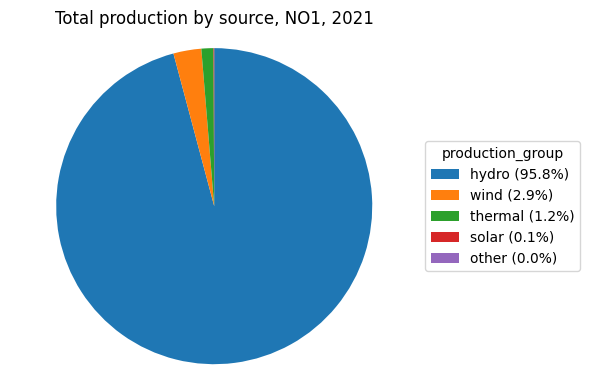

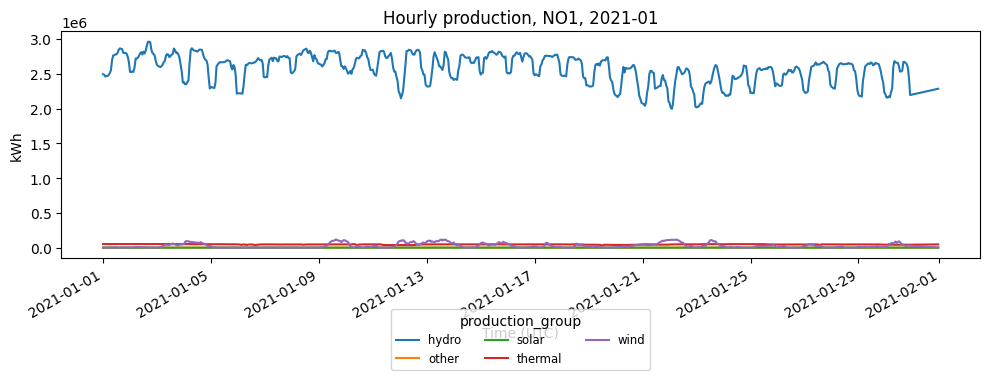

In [13]:
# Pie chart : yearly mix, percentages in legend ---

fig_pie, ax_pie = plt.subplots(figsize=(6, 4))

# values and labels
values = df_yearly_by_group["quantity_kwh"]
labels = df_yearly_by_group["production_group"]

# percentage
total = values.sum()
percentages = (values / total * 100).round(1)
legend_labels = [f"{g} ({p:.1f}%)" for g, p in zip(labels, percentages)]

# camembert without labels or internal text
wedges, _ = ax_pie.pie(values, labels=None, startangle=90, counterclock=False)

ax_pie.set_title(f"Total production by source, {PRICE_AREA}, {YEAR}")
ax_pie.axis("equal")

# legend with percentages
ax_pie.legend(
    wedges,
    legend_labels,
    title="production_group",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


# Line chart : hourly evolution for January ---

df_timeseries_month = df_timeseries_jan.copy()

fig_line, ax_line = plt.subplots(figsize=(10, 4))

df_timeseries_month.plot(ax=ax_line)

ax_line.set_title(f"Hourly production, {PRICE_AREA}, {YEAR}-{MONTH:02d}")
ax_line.set_ylabel("kWh")
ax_line.set_xlabel("Time (UTC)")

ax_line.legend(
    title="production_group",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    fontsize="small"
)

plt.tight_layout()
plt.show()